# Individual Analysis of Online Anomaly Detectors with PV Datasets 

In [ ]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import itertools
params = {
    'font.size': 12,           
    'axes.labelsize': 12,      
    'xtick.labelsize': 10,      
    'ytick.labelsize': 10,      
    'legend.fontsize': 10,      
    'figure.titlesize': 12
}
plt.rcParams.update(params)

from pathlib import Path

import matplotlib.cm as cm
import matplotlib.dates as mdates
from pathlib import Path
import re
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve

from concurrent.futures import ThreadPoolExecutor, as_completed


In [ ]:

DEFAULT_PARAMS_FIXED_WINDOW = pd.array(["HStree_120_{'anomaly_threshold': 0.5, 'max_depth': 15, 'number_of_trees': 25, 'size_limit': 0.1}",
       "xStream_120_{'depth': 25, 'n_chains': 100, 'num_components': 100}",
       "RSHash_120_{'decay': 0.015, 'feature_maxes': [10000], 'feature_mins': [0], 'num_components': 100, 'num_hash_fns': 1}",
       "ExactStorm_120_{'max_radius': 0.1}",
       "RobustRandomCutForest_120_{'num_trees': 4, 'tree_size': 256}",
       "OnlineBootKNN_120_{'algorithm': 'brute', 'alpha': 0.05, 'chunk_size': 240, 'dmetric': 'cityblock', 'ensemble_size': 240, 'n_jobs': -1, 'transf': 'ZNORM'}",
       "oIF_120_{'growth_criterion': 'adaptive', 'max_leaf_samples': 32, 'n_jobs': -1, 'num_trees': 32}",
       "IForestASD_120_{'initial_window_X': None}",
       "KitNet_120_{'hidden_ratio': 0.75, 'learning_rate': 0.1, 'max_size_ae': 10}"],
      dtype=object)

In [ ]:

DEFAULT_PARAMS_NO_FIXED_WINDOW = pd.array(["HStree_60_{'anomaly_threshold': 0.5, 'max_depth': 15, 'number_of_trees': 25, 'size_limit': 0.1}",
       "xStream_60_{'depth': 25, 'n_chains': 100, 'num_components': 100}",
       "RSHash_120_{'decay': 0.015, 'feature_maxes': [10000], 'feature_mins': [0], 'num_components': 100, 'num_hash_fns': 1}",
       "ExactStorm_120_{'max_radius': 0.1}",
       "OnlineBootKNN_120_{'algorithm': 'brute', 'alpha': 0.05, 'chunk_size': 240, 'dmetric': 'cityblock', 'ensemble_size': 240, 'n_jobs': -1, 'transf': 'ZNORM'}",
       "RobustRandomCutForest_240_{'num_trees': 4, 'tree_size': 256}",
       "oIF_240_{'growth_criterion': 'adaptive', 'max_leaf_samples': 32, 'n_jobs': -1, 'num_trees': 32}",
       "IForestASD_240_{'initial_window_X': None}",
       "KitNet_240_{'hidden_ratio': 0.75, 'learning_rate': 0.1, 'max_size_ae': 10}"],
      dtype=object)


In [ ]:
PARAMS=DEFAULT_PARAMS_NO_FIXED_WINDOW

In [ ]:
# Extract the first number after the underscore for each element in PARAMS
WINDOW_LIST = np.unique([re.search(r'_(\d+)_', param).group(1) for param in PARAMS])

print(WINDOW_LIST)

In [6]:
# Get the path to the current script
current_dir = Path.cwd()

# Go one level up
current_dir = current_dir.parent

DATA_PATH = current_dir / 'datasets' / 'processed'

# Define dataset paths
dataset_paths = [
    DATA_PATH / 'processed_server22_A1',
    DATA_PATH / 'processed_server22_A2',
    DATA_PATH / 'processed_server22_A3',
    DATA_PATH / 'processed_server21_A4',
    DATA_PATH / 'processed_server21_A5',
    DATA_PATH / 'processed_L40S02_A6',
    DATA_PATH / 'processed_server18_A7',
    DATA_PATH / 'processed_server18_A8',
    DATA_PATH / 'processed_server18_A9',
]

# Define dataset paths
dataset_paths = [
    DATA_PATH / 'processed_L40S02_A6',

]

def process_file(file_path, scenario):
    try:
        print(f"Processing file: {file_path.name} for scenario: {scenario}") # Now printing the scenario
        df = pd.read_excel(file_path)
        df["window_size"] = file_path.name.split("_")[-1].replace(".xlsx", "")
        df["method_window_and_param"] = df.method + "_" + df.window_size + "_" + df.param
        df = df[df['method_window_and_param'].isin(PARAMS)]

        # Example: Add a 'scenario' column to the DataFrame
        df['scenario'] = scenario

        return df if not df.empty else None
    except Exception as e:
        print(f"Error processing {file_path.name}: {e}")
        return None

def process_path(path):
    SCENARIO = path.name.split("_")[-1]
    print(f"Processing path: {path.name}")
    if not path.is_dir():
        return []
    
    files = [f for f in path.iterdir() if f.suffix == '.xlsx' and f.name.startswith('A')]
    print(f"Total Files for the Scenario {SCENARIO}: {len(files)}")
    
    dfs = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_file, file, SCENARIO) for file in files]
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                dfs.append(result)
    return dfs

# Main execution
all_dfs = []
for dataset_path in dataset_paths:
    all_dfs.extend(process_path(dataset_path))

# Concatenate all DataFrames at once
concatenated_df = pd.concat(all_dfs, ignore_index=True)


In [7]:
SCENARIO = concatenated_df['scenario'].unique()[0] 
SCENARIO

'A6'

In [8]:
concatenated_df["timestamp"] = pd.to_datetime(concatenated_df["timestamp"])
concatenated_df["cleaned_score"] = concatenated_df["cleaned_score"].astype('float64')


In [9]:
regex_filter = r"OnlineBootMGV|LODA|Py"
filtered_data = concatenated_df[~concatenated_df['method'].str.contains(regex_filter, regex=True)]
#filtered_data = filtered_data[filtered_data['method'].str.contains("std_p")]
#filtered_data = filtered_data[filtered_data['method'].str.contains("None|FOD|SOD|DIL|QUANT")]
#filtered_data = filtered_data[filtered_data['method'].str.contains("QUANT")]
#filtered_data = filtered_data[filtered_data.method.str.contains("OnlineBootGP|OnlineBootKNN")]

filtered_data["timestamp"] = pd.to_datetime(filtered_data["timestamp"])
filtered_data["cleaned_score"] = filtered_data["cleaned_score"].astype('float64')


In [33]:
new_method_name = {"xStream":"XStream", "RSHash":"RSHash", "IForestASD":"IFASD", "RobustRandomCutForest":"RRCF", "KitNet":"KitNet", "ExactStorm":"EStorm","oIF":"OIF", "HStree":"HStree", "OnlineBootKNN":"OBKNN"} 

filtered_data["method"] = filtered_data['method'].replace(new_method_name)

# Get the final list of unique merged combinations
methods = filtered_data.method.unique()
#methods = ['IForestASD', 'KitNet', 'oIF', 'RobustRandomCutForest' ,'xStream', 'HStree','RSHash' ,'ExactStorm' ,'OnlineBootKNN']
print(methods)


['IFASD' 'KitNet' 'OIF' 'RRCF' 'XStream' 'HStree' 'RSHash' 'EStorm'
 'OBKNN']


In [34]:
print(PARAMS)

<NumpyExtensionArray>
[                                                          "HStree_60_{'anomaly_threshold': 0.5, 'max_depth': 15, 'number_of_trees': 25, 'size_limit': 0.1}",
                                                                                          "xStream_60_{'depth': 25, 'n_chains': 100, 'num_components': 100}",
                                      "RSHash_120_{'decay': 0.015, 'feature_maxes': [10000], 'feature_mins': [0], 'num_components': 100, 'num_hash_fns': 1}",
                                                                                                                        "ExactStorm_120_{'max_radius': 0.1}",
 "OnlineBootKNN_120_{'algorithm': 'brute', 'alpha': 0.05, 'chunk_size': 240, 'dmetric': 'cityblock', 'ensemble_size': 240, 'n_jobs': -1, 'transf': 'ZNORM'}",
                                                                                              "RobustRandomCutForest_240_{'num_trees': 4, 'tree_size': 256}",
                              

In [35]:
# Get the final list of unique merged combinations

method_window_and_param = filtered_data["method_window_and_param"].unique()
print(method_window_and_param)

["IForestASD_240_{'initial_window_X': None}"
 "KitNet_240_{'hidden_ratio': 0.75, 'learning_rate': 0.1, 'max_size_ae': 10}"
 "oIF_240_{'growth_criterion': 'adaptive', 'max_leaf_samples': 32, 'n_jobs': -1, 'num_trees': 32}"
 "RobustRandomCutForest_240_{'num_trees': 4, 'tree_size': 256}"
 "xStream_60_{'depth': 25, 'n_chains': 100, 'num_components': 100}"
 "HStree_60_{'anomaly_threshold': 0.5, 'max_depth': 15, 'number_of_trees': 25, 'size_limit': 0.1}"
 "RSHash_120_{'decay': 0.015, 'feature_maxes': [10000], 'feature_mins': [0], 'num_components': 100, 'num_hash_fns': 1}"
 "ExactStorm_120_{'max_radius': 0.1}"
 "OnlineBootKNN_120_{'algorithm': 'brute', 'alpha': 0.05, 'chunk_size': 240, 'dmetric': 'cityblock', 'ensemble_size': 240, 'n_jobs': -1, 'transf': 'ZNORM'}"]


In [36]:
num_colors = len(method_window_and_param)
print("Total Hyperparameter Tuning: ", num_colors)


Total Hyperparameter Tuning:  9


In [37]:
#methods = np.array(['RSHash', 'RobustRandomCutForest', 'KitNet', 'ExactStorm', 'IForestASD', 'oIF', 'HStree', 'OnlineBootKNN','xStream'], dtype=object)

In [38]:
# Define a color list (consider using a color palette from seaborn or matplotlib)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


# Generate a list of colors corresponding to the methods
color_list = [colors[i] for i in range(num_colors)]

print(color_list)  # Display the first 10 colors

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']


In [39]:
# Generate the summary of cleaned process to the score
filtered_data['error_type_score'] = filtered_data['error_type_score'].fillna("No Error")
filtered_data.pivot_table(index='method', columns='error_type_score', values='cleaned_score', aggfunc='count')


error_type_score,Array Output Assigned the First Value.,NaN Output Assigned to 0 (Pandas).,No Error
method,,,
EStorm,NaN,NaN,21000.0
HStree,NaN,NaN,21000.0
IFASD,NaN,NaN,21000.0
KitNet,NaN,5.0,20995.0
OBKNN,NaN,NaN,21000.0
OIF,NaN,NaN,21000.0
RRCF,NaN,NaN,21000.0
RSHash,NaN,NaN,21000.0
XStream,21000.0,NaN,NaN


In [40]:
iterations = filtered_data["iteration"].unique()[0:10]
iterations

array([2, 3, 1, 4, 0])

## Individual Score of Online Anomaly Detectors with Pfeiffer Vacuum Datasets 

In [41]:
# Group data by method and timestamp, calculating both the mean and std
average_results = filtered_data.groupby(['method',  'timestamp'], as_index=False).agg(
    mean_score=('cleaned_score', 'mean'),
    std_score=('cleaned_score', 'std'),
    mean_gt=('ground_truth', 'mean')
)


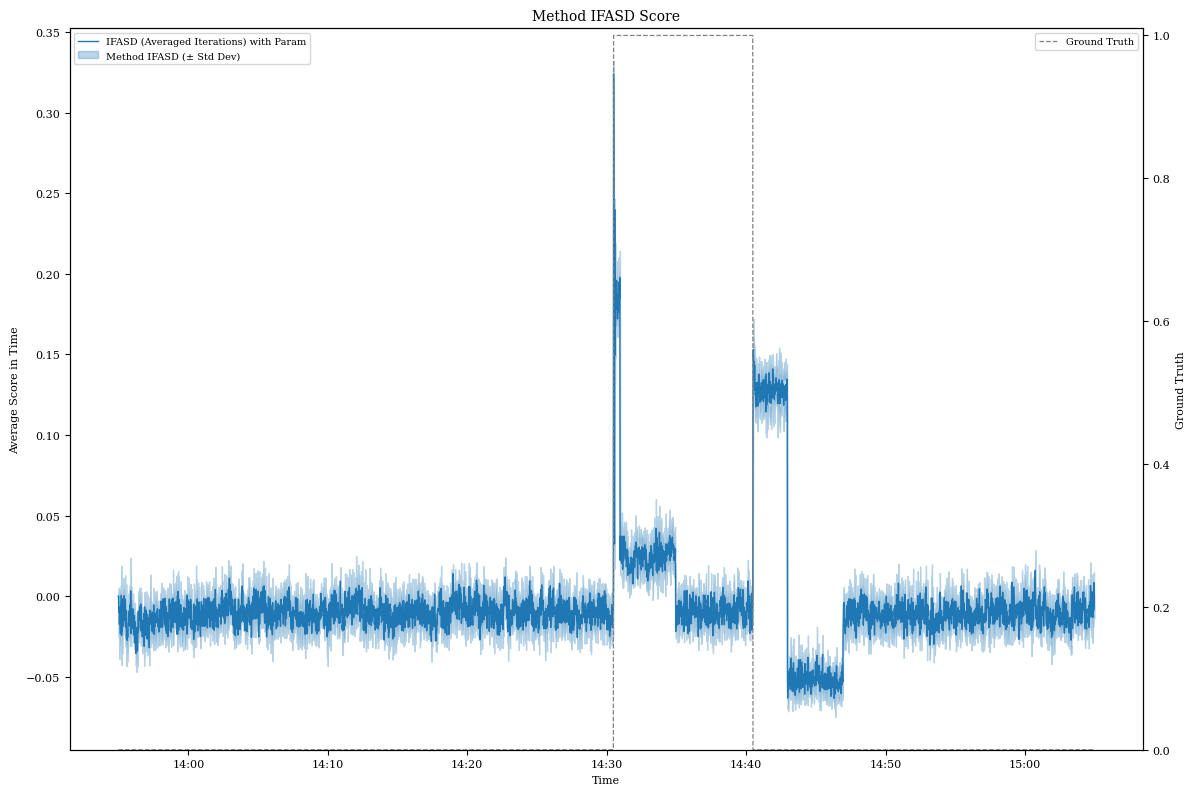

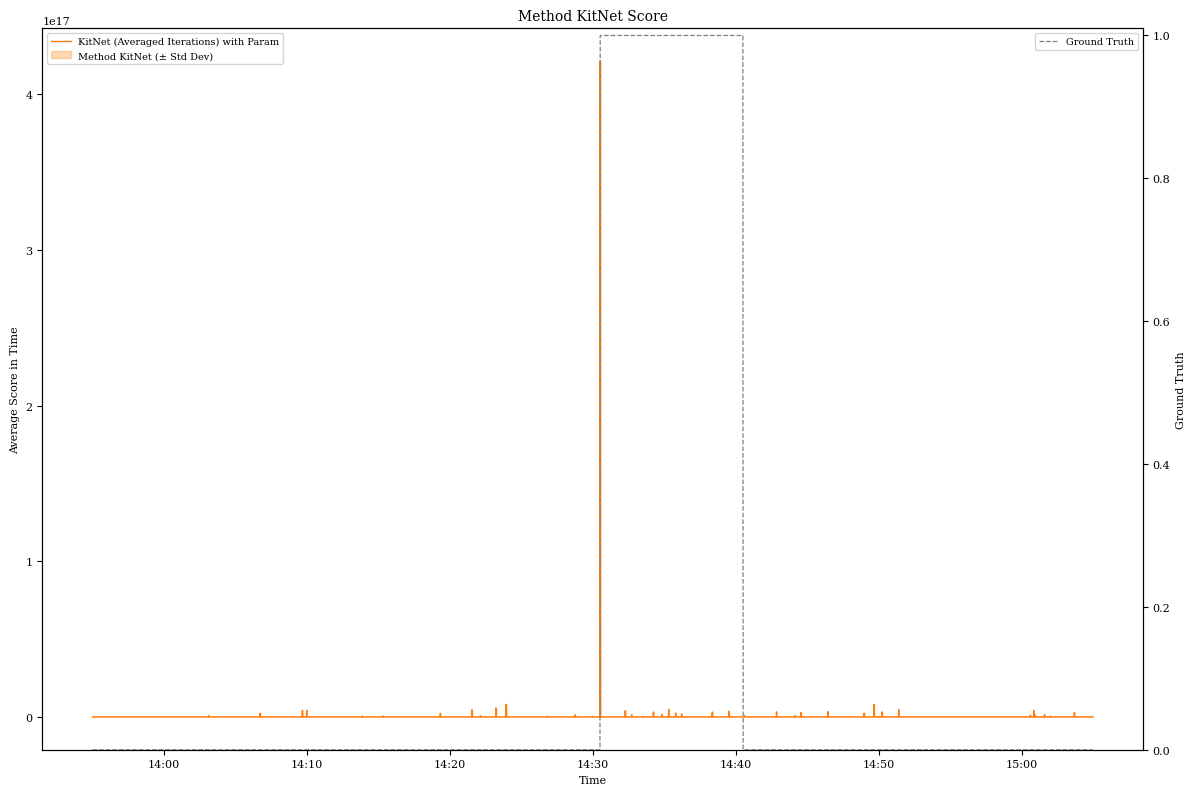

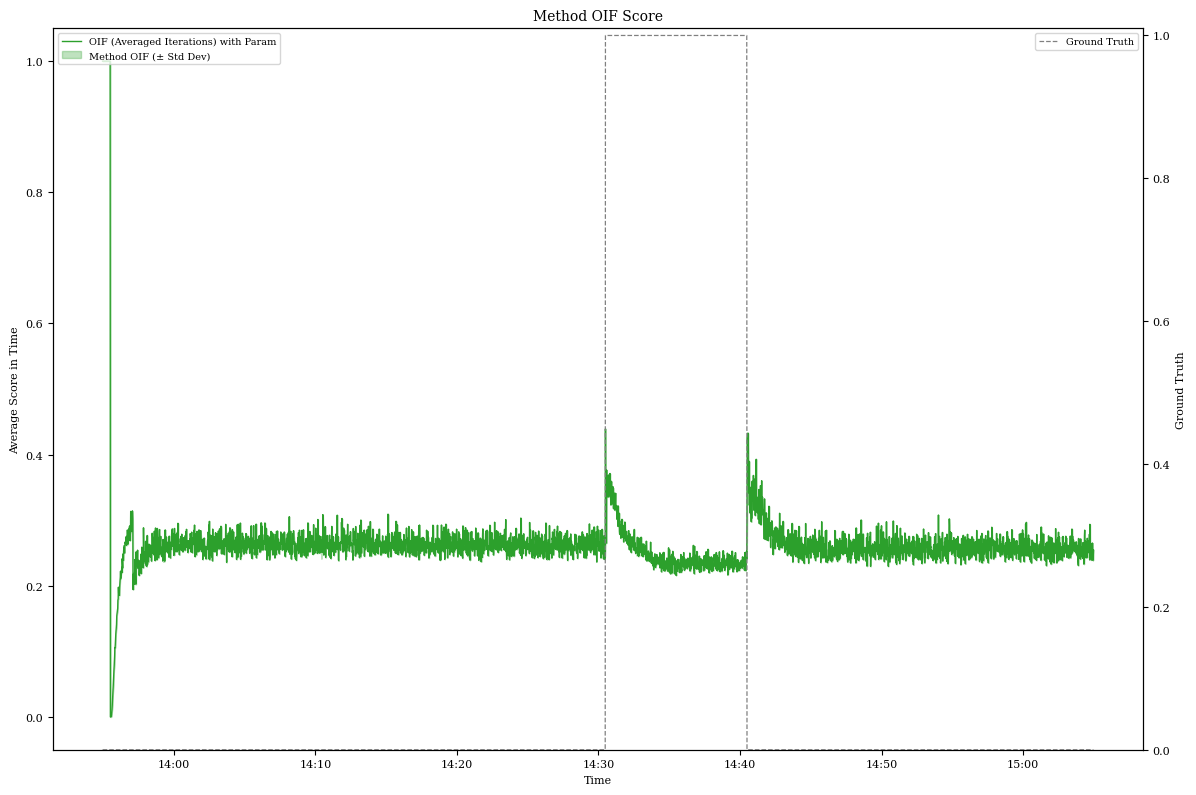

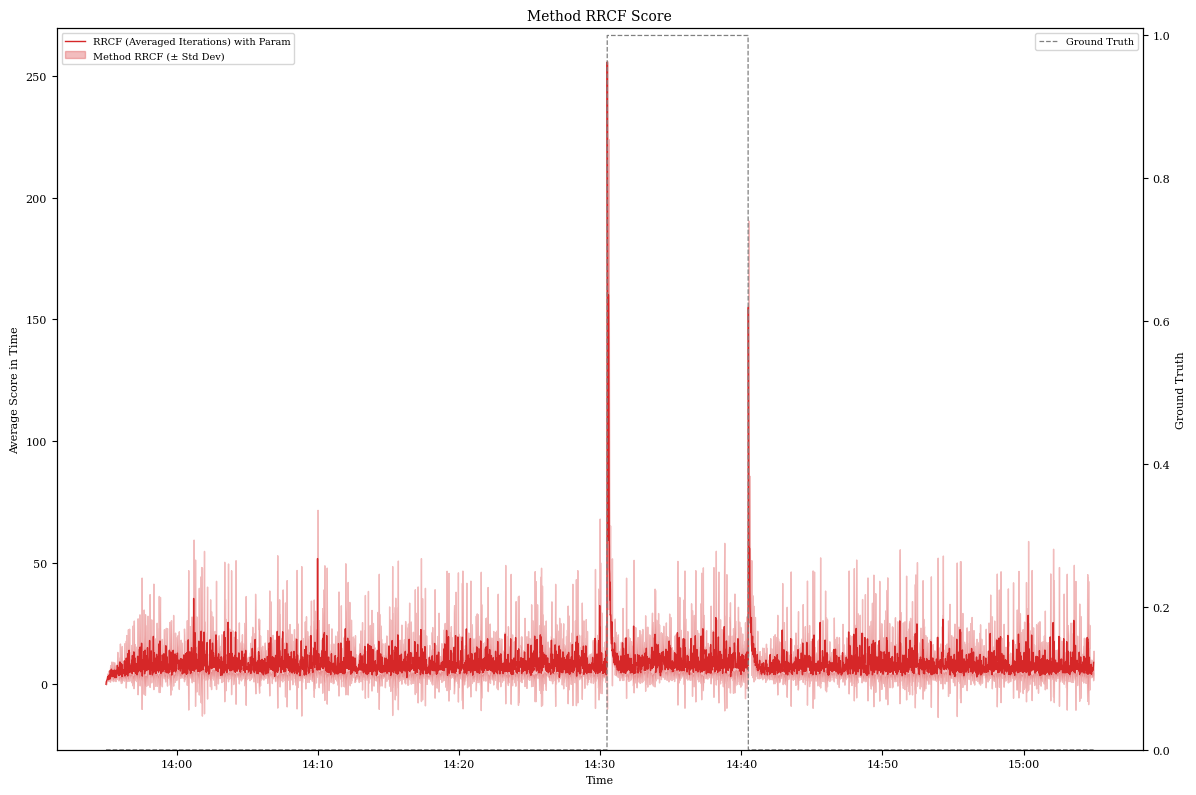

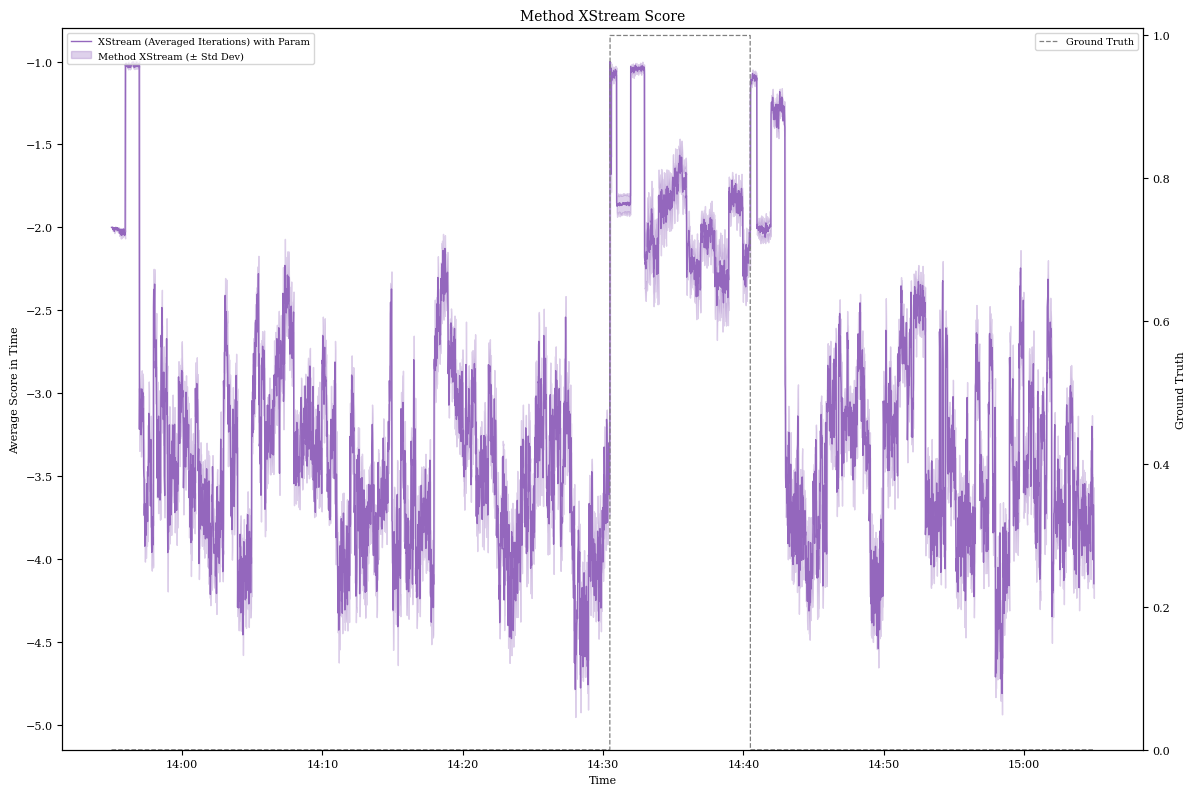

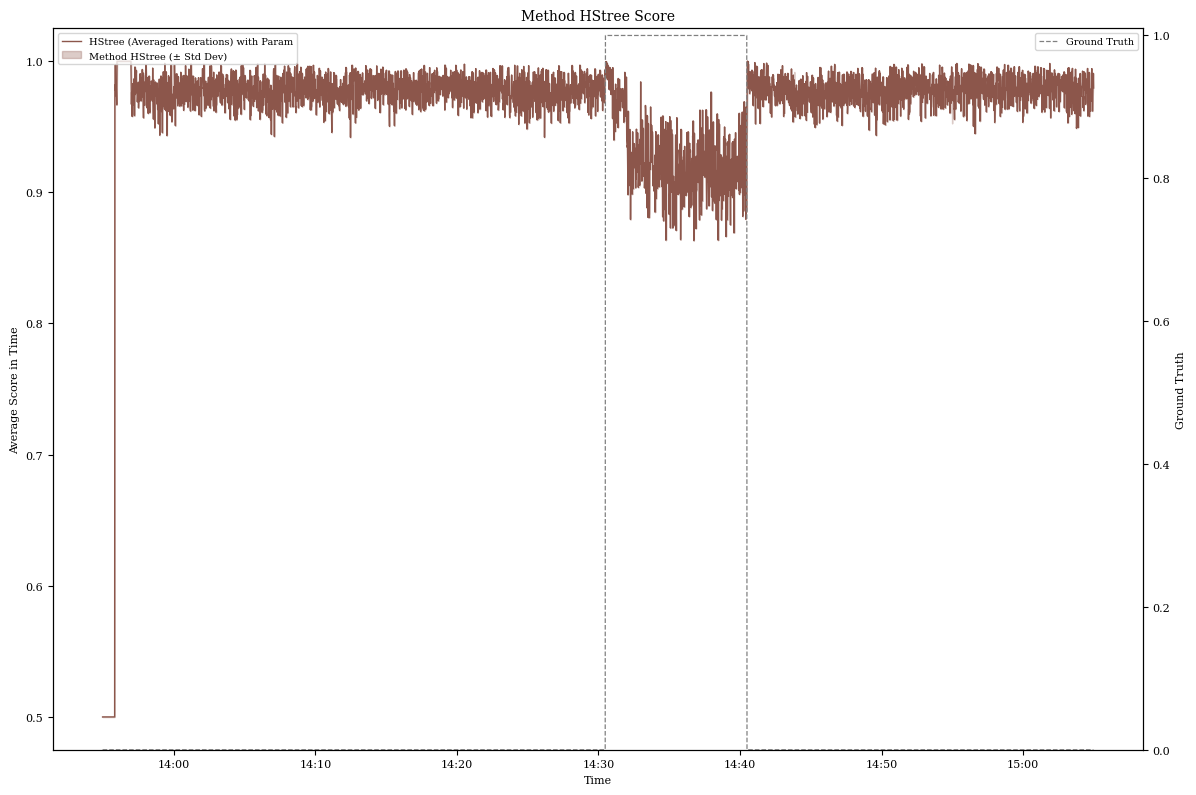

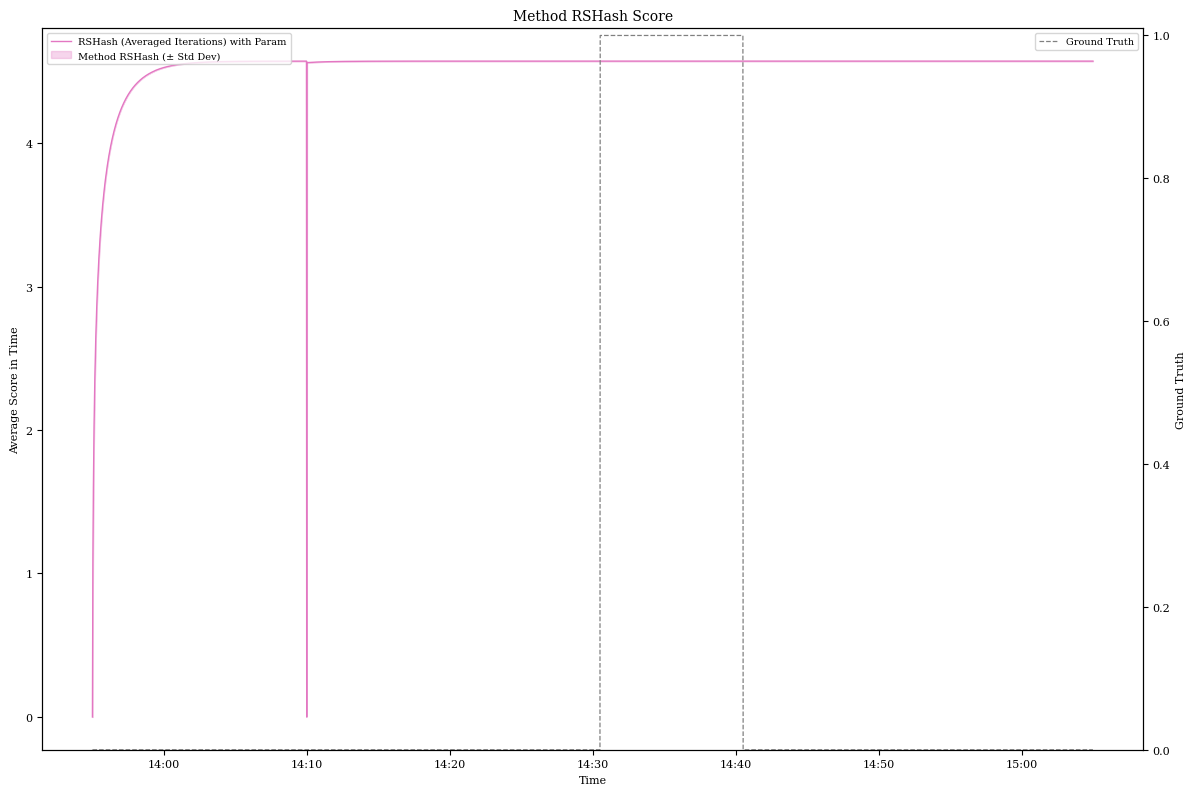

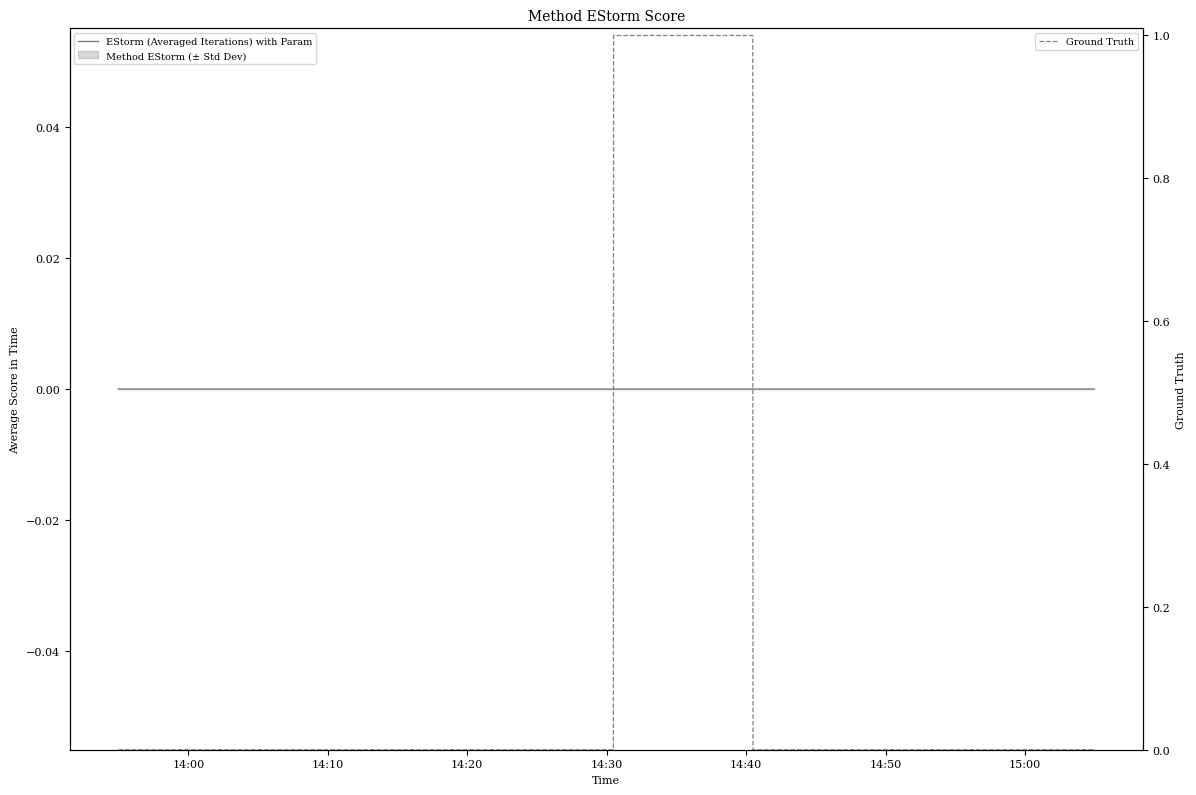

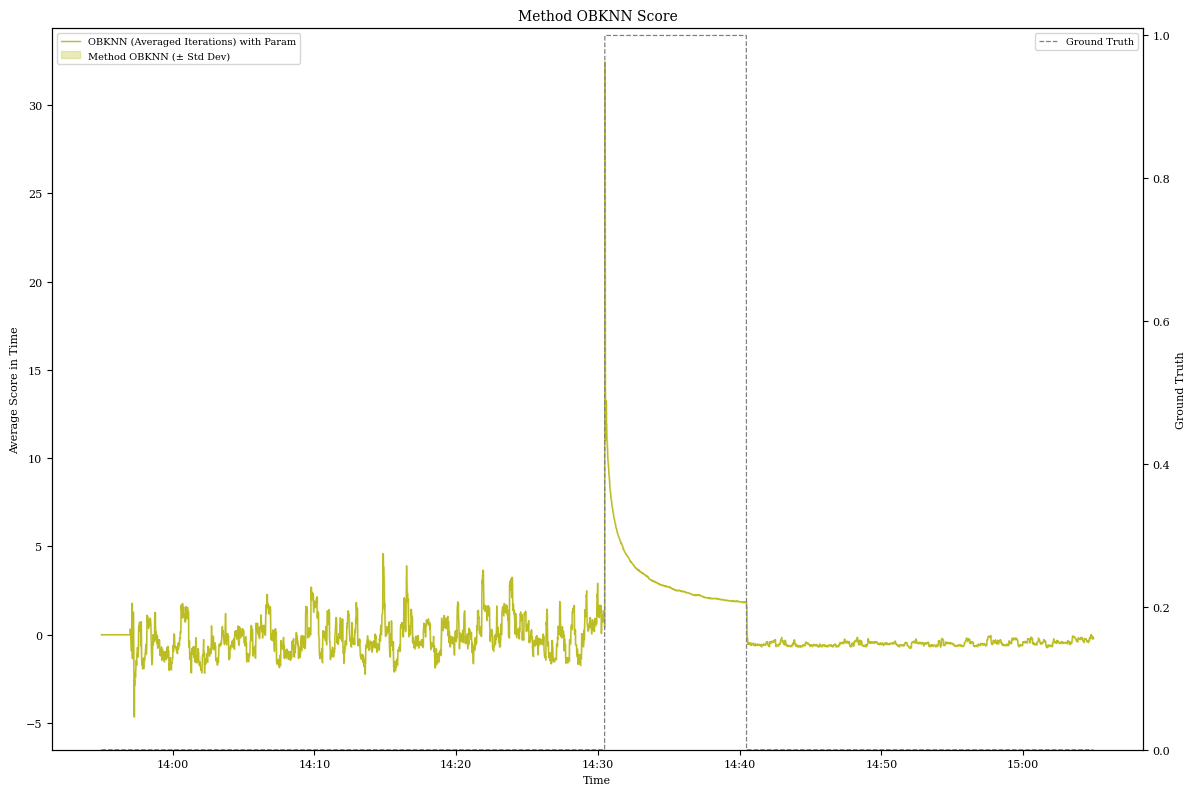

In [42]:
# Loop through methods and plot the averaged values and std
for m, color in zip(methods, color_list):
    # Create a single figure
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Filter data for the current method
    method_data = average_results[(average_results["method"] == m)]
    
    # Plot the mean score
    ax1.plot(
        method_data['timestamp'], 
        method_data['mean_score'], 
        label=f'{m} (Averaged Iterations) with Param', 
        color=color
    )
    
    # Plot the standard deviation as a shaded area on the first axis
    ax1.fill_between(
        method_data['timestamp'], 
        method_data['mean_score'] - method_data['std_score'], 
        method_data['mean_score'] + method_data['std_score'], 
        color=color, alpha=0.3, label=f'Method {m} (± Std Dev)'
    )

    # Set labels and title for the first y-axis
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Average Score in Time')
    ax1.set_title(f"Method {m} Score")
    
    # Create a second y-axis
    ax2 = ax1.twinx()
    
    # Plot the Ground Truth on the second y-axis
    ax2.plot(
        method_data['timestamp'], 
        method_data['mean_gt'], 
        label='Ground Truth', 
        color='grey', linestyle='--',
        linewidth=0.9  # Make the line very thin
    )
    
    # Set label for the second y-axis
    ax2.set_ylabel('Ground Truth')
    
    # Adjust the second y-axis range (this is the key part to scale it visually)
    ax2.set_ylim(0, 1.01)  # Scale the ground truth values down (50% here)

    # Add legends and grid
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(False)  # Remove gridlines
    
    # Format the x-axis to show only the hours
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # Improve layout and display
    ax1.tick_params(axis='x')  # larger x-axis labels

    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot
    plt.savefig(current_dir / 'notebooks' / 'score_functions'/ f"{SCENARIO}_score_{m}.pdf", format="pdf")
    
    # Display the plot
    plt.show()


Method: IFASD, Iteration: 2
Method: IFASD, Iteration: 3
Method: IFASD, Iteration: 4
Method: IFASD, Iteration: 0
Method: IFASD, Iteration: 1


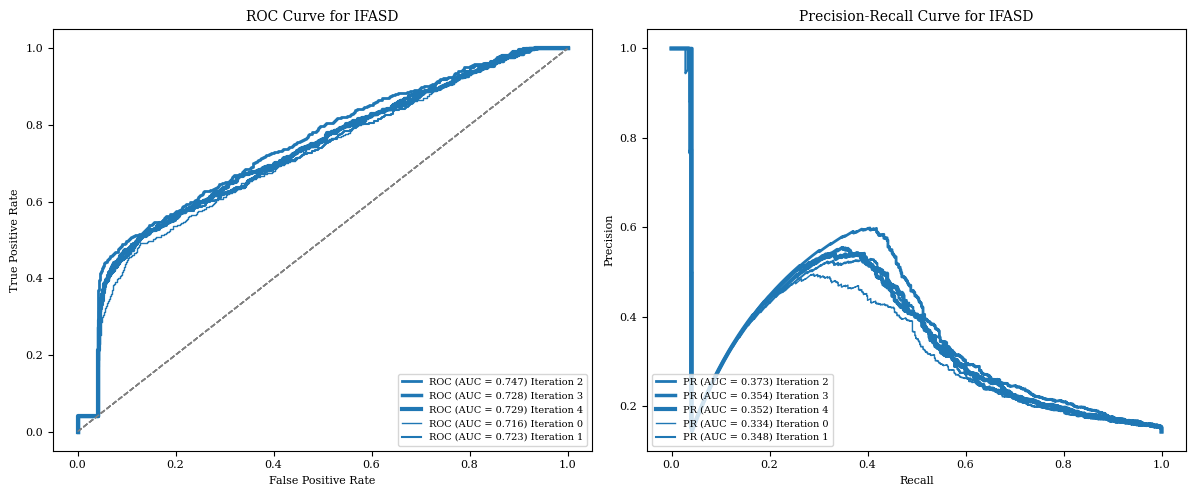

Method: KitNet, Iteration: 2
Method: KitNet, Iteration: 3
Method: KitNet, Iteration: 4
Method: KitNet, Iteration: 0
Method: KitNet, Iteration: 1


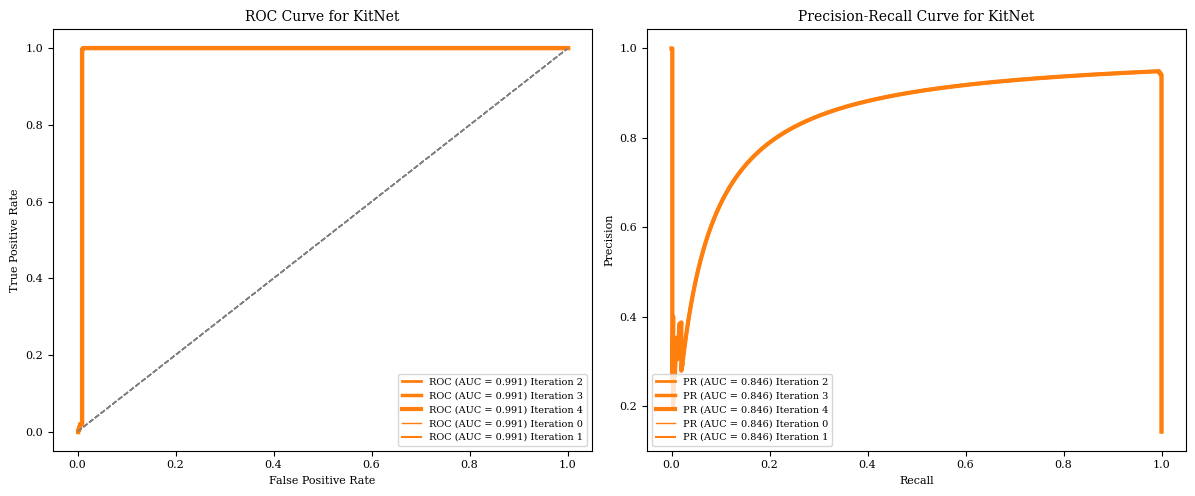

Method: OIF, Iteration: 2
Method: OIF, Iteration: 3
Method: OIF, Iteration: 4
Method: OIF, Iteration: 0
Method: OIF, Iteration: 1


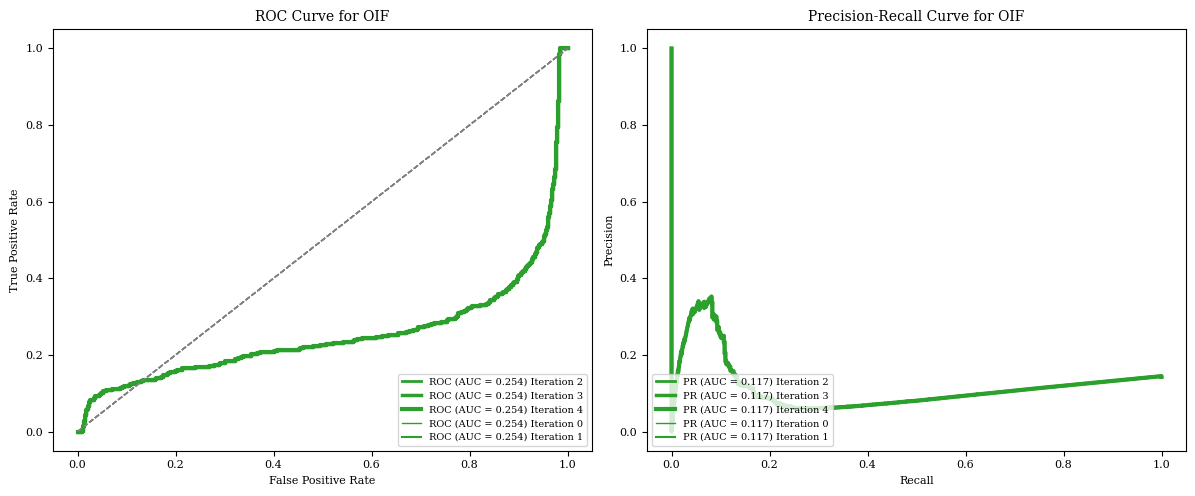

Method: RRCF, Iteration: 2
Method: RRCF, Iteration: 3
Method: RRCF, Iteration: 4
Method: RRCF, Iteration: 0
Method: RRCF, Iteration: 1


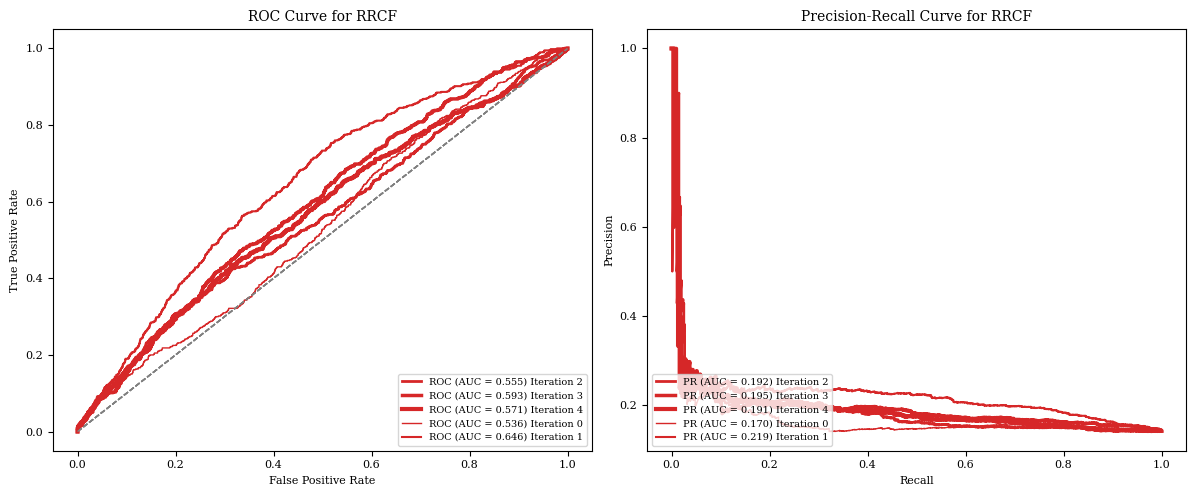

Method: XStream, Iteration: 2
Method: XStream, Iteration: 1
Method: XStream, Iteration: 3
Method: XStream, Iteration: 4
Method: XStream, Iteration: 0


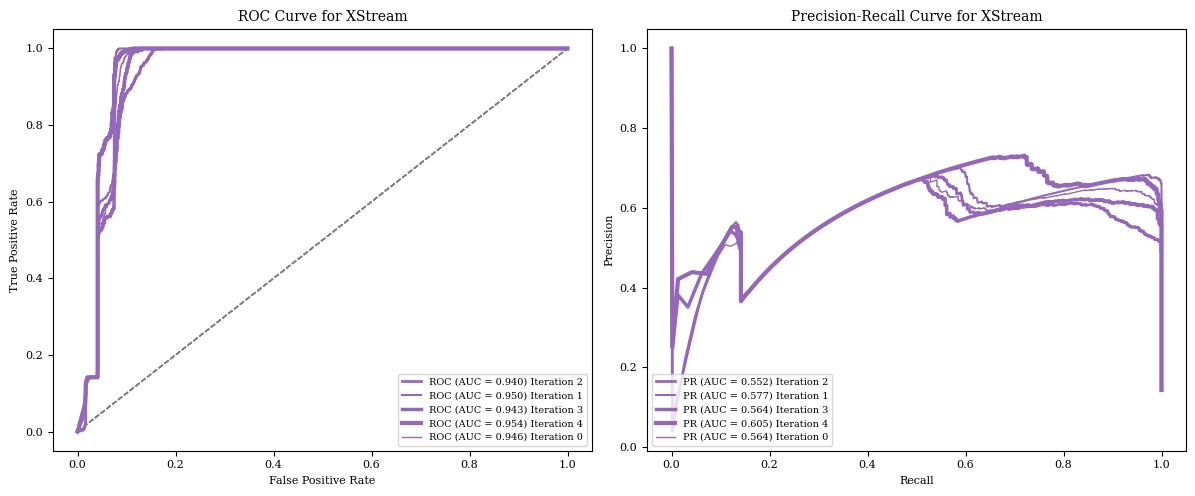

Method: HStree, Iteration: 2
Method: HStree, Iteration: 1
Method: HStree, Iteration: 3
Method: HStree, Iteration: 4
Method: HStree, Iteration: 0


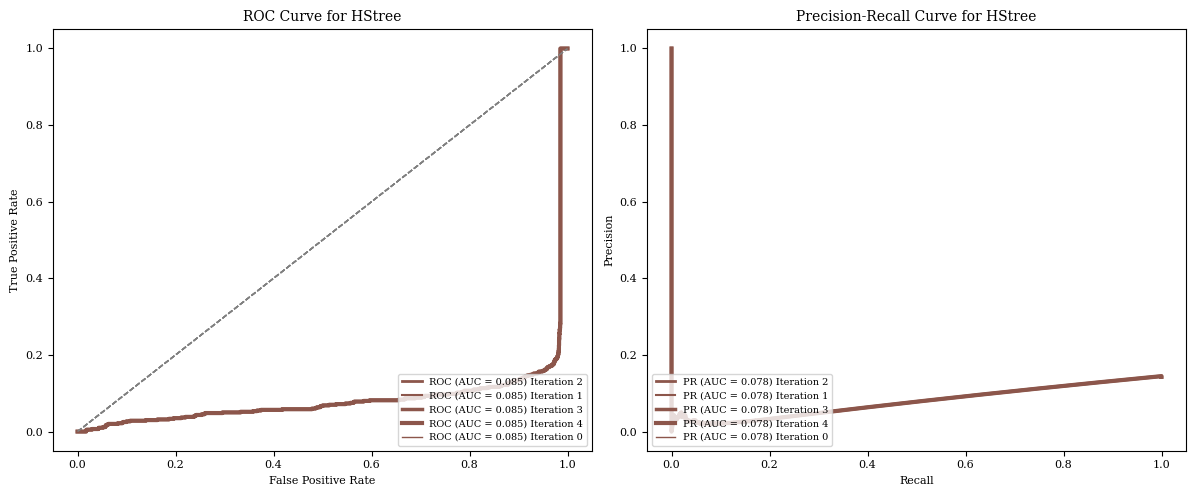

Method: RSHash, Iteration: 3
Method: RSHash, Iteration: 4
Method: RSHash, Iteration: 2
Method: RSHash, Iteration: 0
Method: RSHash, Iteration: 1


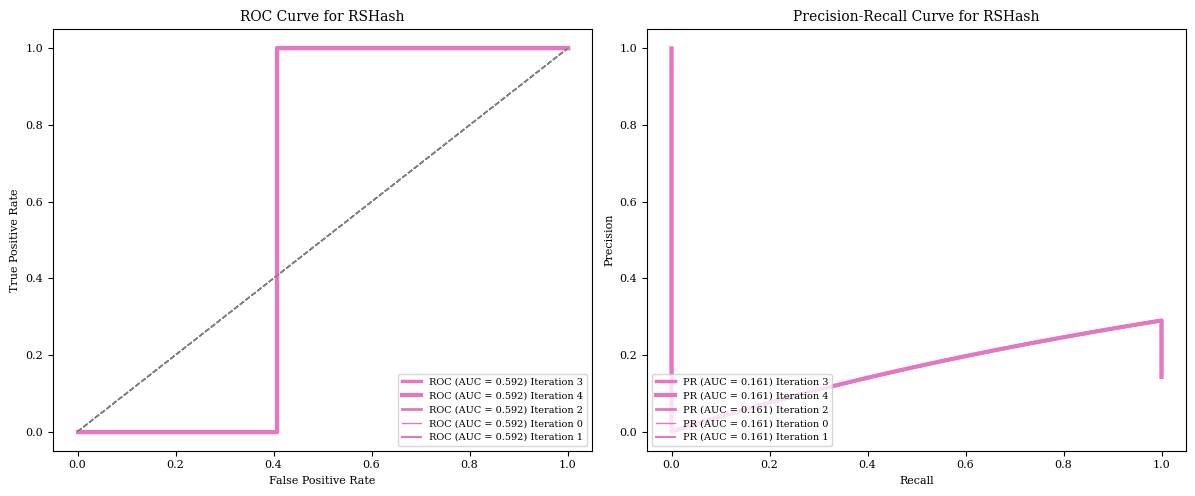

Method: EStorm, Iteration: 3
Method: EStorm, Iteration: 4
Method: EStorm, Iteration: 2
Method: EStorm, Iteration: 0
Method: EStorm, Iteration: 1


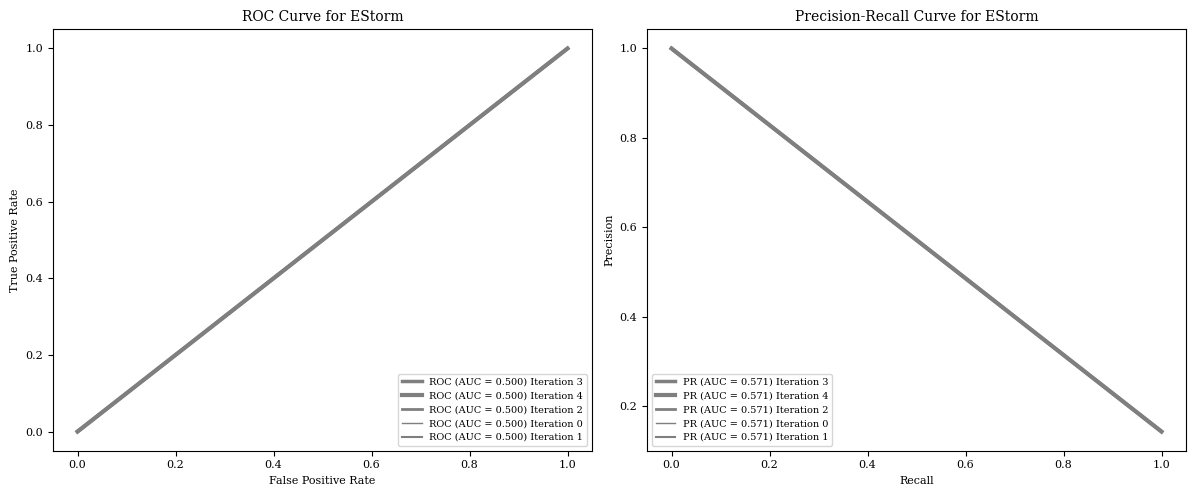

Method: OBKNN, Iteration: 3
Method: OBKNN, Iteration: 4
Method: OBKNN, Iteration: 2
Method: OBKNN, Iteration: 0
Method: OBKNN, Iteration: 1


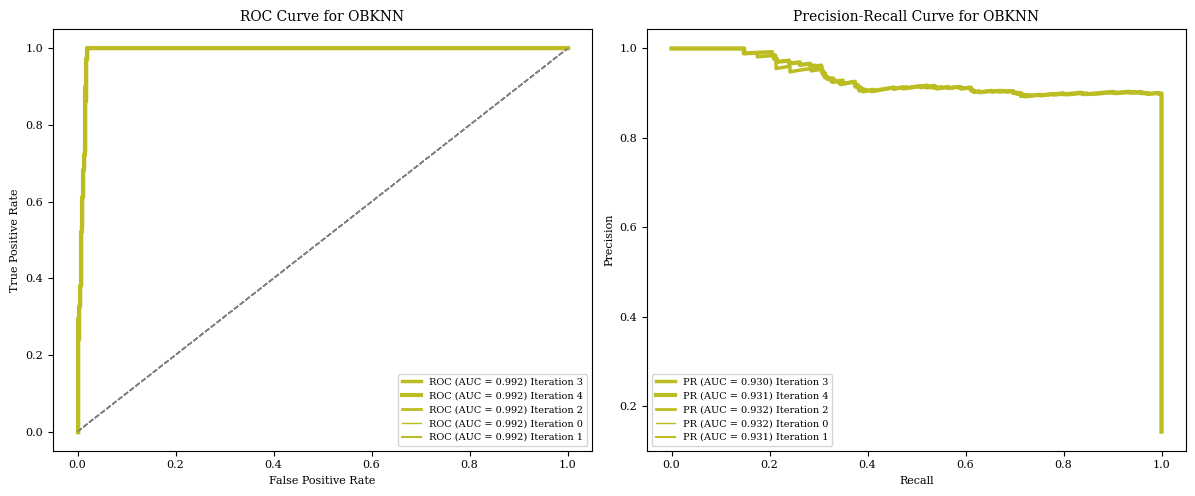

In [43]:

for m, color in zip(methods, color_list):
    # Plot ROC Curve
    plt.figure(figsize=(12, 5))
    f_method_data = filtered_data[filtered_data['method'] == m]
    
    for i in f_method_data['iteration'].unique():
        
        print(f"Method: {m}, Iteration: {i}")
        # Filter data for the current method and iteration
        method_data = f_method_data[f_method_data['iteration'] == i]

        # Get true labels and scores
        y_true = method_data['ground_truth'].values
        y_scores = method_data['cleaned_score'].values

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Compute Precision-Recall curve and AUC
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall, precision)



        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color=color, lw=1 + i * 0.5, label=f'ROC (AUC = {roc_auc:.3f}) Iteration {i}')


        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {m}')
        plt.legend(loc='lower right')

        # Plot Precision-Recall Curve
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, color=color, lw=1 + i * 0.5, label=f'PR (AUC = {pr_auc:.3f}) Iteration {i}')


        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {m}')
        plt.legend(loc='lower left')

        plt.tight_layout()
    plt.show()




## Individual Training Time of Online Anomaly Detectors with PV Datasets 

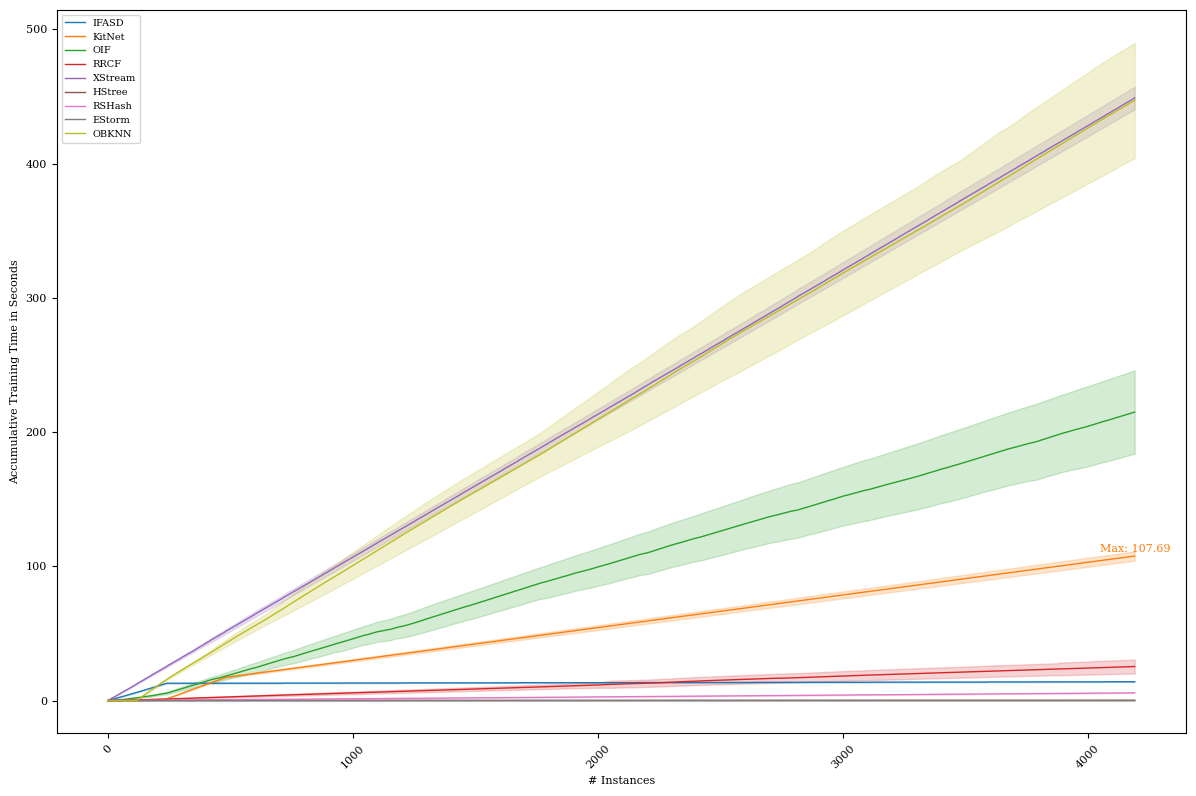

In [44]:
# Create a single figure
plt.figure(figsize=(12, 8))

# Group data by method and timestamp, calculating mean and standard deviation across iterations
grouped_data = filtered_data.groupby(['method', 'timestamp']).agg(
    mean_training_time_t=('training_time', 'mean'),
    std_training_time_t=('training_time', 'std')
).reset_index()

# Loop through methods and plot the accumulated values with shaded area
for m, color in zip(methods, color_list):
    
    method_data = grouped_data[grouped_data["method"] == m]

    # Compute cumulative sum
    cumulative_training_time = method_data['mean_training_time_t'].expanding().sum()

    # Plot averaged training time with accumulation
    plt.plot(
        range(len(method_data['timestamp'])),  # Use the index as x-axis
        cumulative_training_time,
        label=f'{m}',
        color=color
    )

    # Plot shaded area representing standard deviation
    plt.fill_between(
        range(len(method_data['timestamp'])),  # Use the index as x-axis
        (method_data['mean_training_time_t'] - method_data['std_training_time_t']).expanding().sum(),
        (method_data['mean_training_time_t'] + method_data['std_training_time_t']).expanding().sum(),
        color=color,
        alpha=0.2
    )

    # Get max accumulated training time and timestamp
    max_time = cumulative_training_time.max()

    max_timestamp = len(method_data['timestamp'])  # Ensuring correct index

    # Format the max value properly
    formatted_max_time = f"{max_time:,.2f}"  # Adds commas and rounds to 2 decimals

    if m in ["OnlineBootKNN", "xStream", "KitNet"]:
        # Annotate the max value
        plt.annotate(
            f'Max: {formatted_max_time}', 
            xy=(max_timestamp, max_time), 
            xytext=(max_timestamp, max_time * 1.03),  # Adjusted for better visibility
            #arrowprops=dict(facecolor=color, arrowstyle='->'),
            color=color,
            ha='center'
        )

# Format the x-axis to show only the hours
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
# Adding labels and title
#plt.title("Training Time", fontsize=FONTSIZE_SEC)
plt.xlabel('# Instances')
plt.ylabel('Accumulative Training Time in Seconds')
plt.legend(loc='upper left')  # Place legend dynamically
plt.xticks(rotation=45)
#plt.grid(True, linestyle='--', alpha=0.6)  # Improve grid visibility
plt.tight_layout()

plt.savefig(current_dir / 'notebooks' / 'img_training_and_scoring_time'/f"{SCENARIO}_accum_training_time.pdf", format="pdf")
# Display the plot
plt.show()


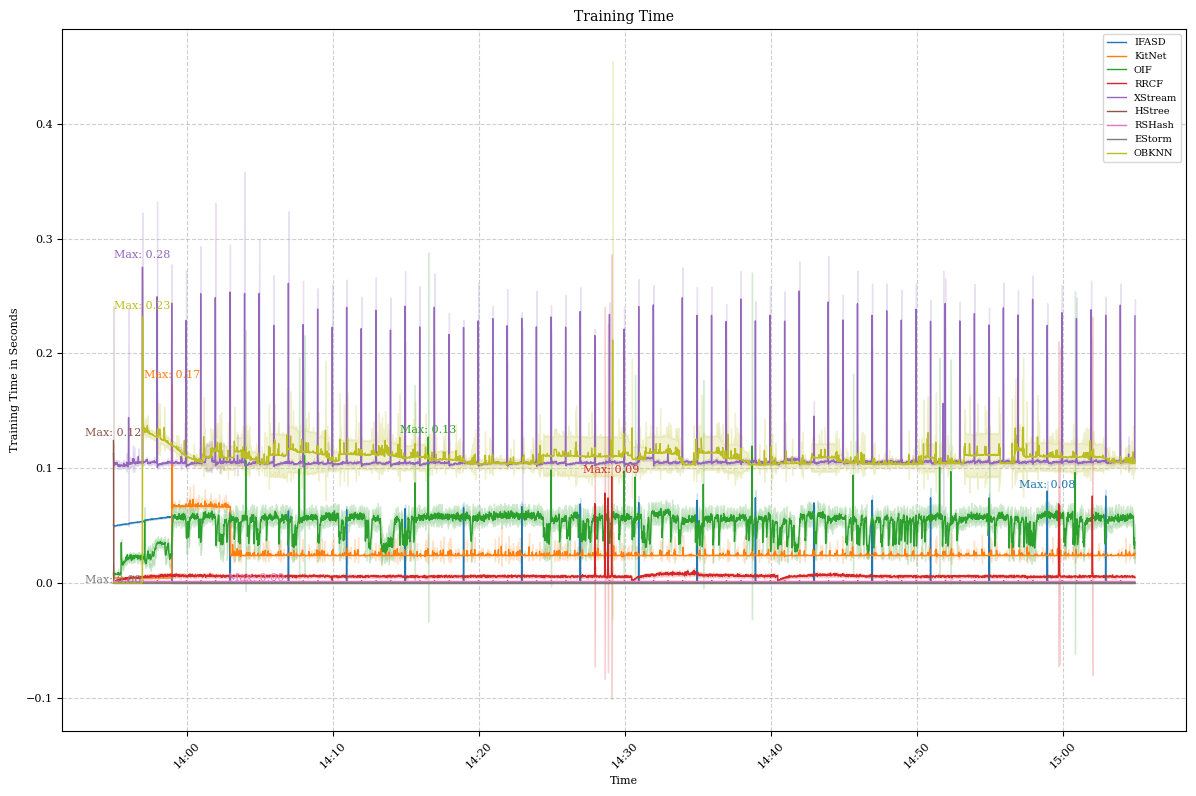

In [45]:
# Create a single figure
plt.figure(figsize=(12, 8))

# Group data by method and timestamp, calculating mean and standard deviation across iterations
grouped_data = filtered_data.groupby(['method', 'timestamp']).agg(
    mean_training_time_t=('training_time', 'mean'),
    std_training_time_t=('training_time', 'std')
).reset_index()


for m, color in zip(methods, color_list):
    
    method_data = grouped_data[grouped_data["method"] == m]

    
    training_time = method_data['mean_training_time_t']

    # Plot averaged training time 
    plt.plot(
        method_data['timestamp'],
        training_time,
        label=f'{m}',
        color=color
    )

    # Plot shaded area representing standard deviation
    plt.fill_between(
        method_data['timestamp'],
        (method_data['mean_training_time_t'] - method_data['std_training_time_t']),
        (method_data['mean_training_time_t'] + method_data['std_training_time_t']),
        color=color,
        alpha=0.2
    )

    
    max_time = training_time.max()
    max_idx = training_time.idxmax()
    max_timestamp = method_data.loc[max_idx, 'timestamp']  # Ensuring correct index

    # Format the max value properly
    formatted_max_time = f"{max_time:,.2f}"  # Adds commas and rounds to 2 decimals

    # Annotate the max value
    plt.annotate(
        f'Max: {formatted_max_time}', 
        xy=(max_timestamp, max_time), 
        xytext=(max_timestamp, max_time * 1.03),  # Adjusted for better visibility
        #arrowprops=dict(facecolor=color, arrowstyle='->'),
        color=color,
        ha='center'
    )
# Format the x-axis to show only the hours
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Training Time in Seconds')
plt.legend(loc='best')  # Place legend dynamically
plt.title("Training Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)  # Improve grid visibility
plt.tight_layout()

#plt.savefig(f"/home/nicolas/spectral_anomaly_detector/notebooks/img_training_and_scoring_time/{SCENARIO}_training_time.png", format="png")
# Display the plot
plt.show()


In [46]:
# Group by method and compute training time statistics
training_time_stats = filtered_data.groupby(['method', 'timestamp'])['training_time'].agg(
    mean_training_time_t='mean',
).reset_index()

training_time_stats = training_time_stats.groupby(['method'])['mean_training_time_t'].agg(
    mean_time='mean',
    median_time='median',
    min_time='min',
    max_time='max',
    std_dev_time='std'
).reset_index()

# Sort by mean training time in ascending order
training_time_stats = training_time_stats.sort_values(by='mean_time', ascending=True)

# Display summary
training_time_stats

,method,mean_time,median_time,min_time,max_time,std_dev_time
0,EStorm,0.000002,1.573563e-06,4.768372e-07,0.000008,3.193146e-07
1,HStree,0.000070,8.535385e-06,4.816055e-06,0.124083,1.931656e-03
7,RSHash,0.001378,1.376867e-03,1.358175e-03,0.001660,9.999055e-06
2,IFASD,0.003349,9.536743e-07,7.152557e-07,0.080045,1.318304e-02
6,RRCF,0.006055,5.884552e-03,1.144409e-05,0.092683,2.988782e-03
3,KitNet,0.025682,2.401886e-02,4.394531e-03,0.173369,1.146395e-02
5,OIF,0.051242,5.550103e-02,6.073761e-03,0.127134,1.087976e-02
4,OBKNN,0.106610,1.094259e-01,4.329681e-05,0.231685,1.920834e-02
8,XStream,0.107066,1.049131e-01,1.006699e-01,0.275079,1.651097e-02


## Individual Scoring Time of Online Anomaly Detectors with PV Datasets 

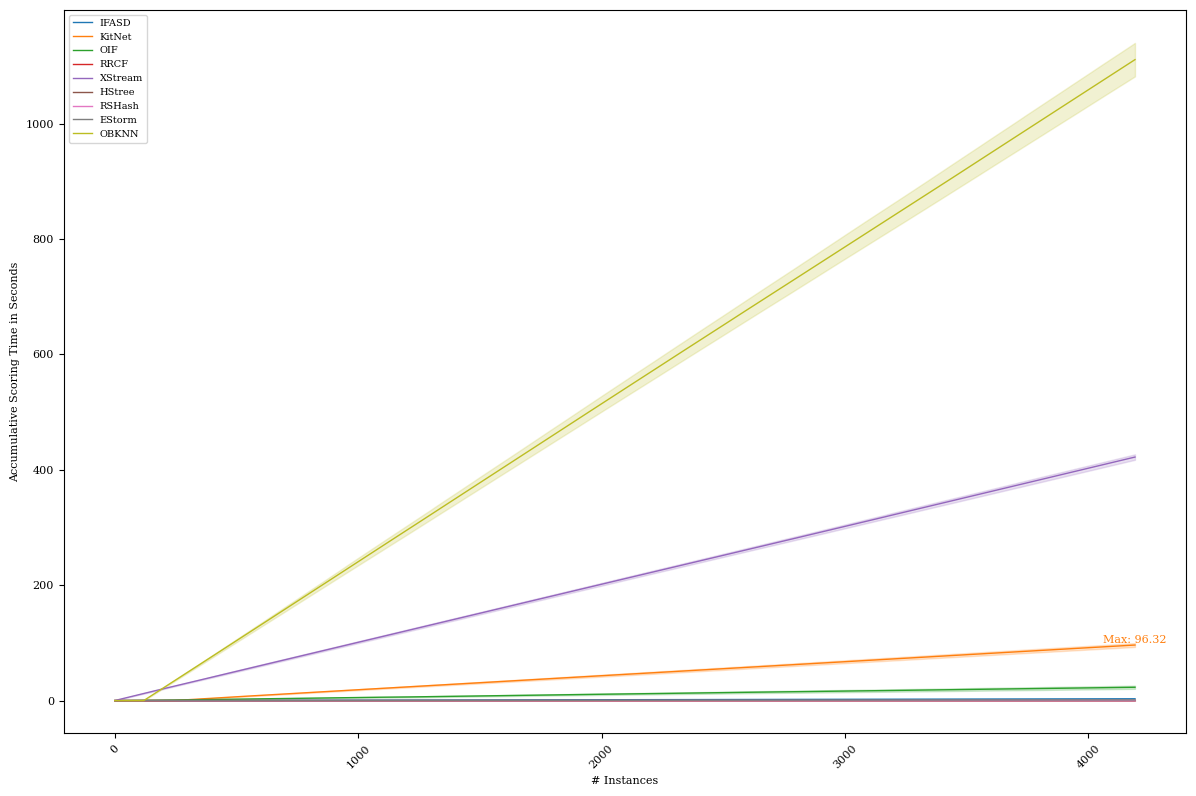

In [47]:
# Create a single figure
plt.figure(figsize=(12, 8))

# Group data by method and timestamp, calculating mean and standard deviation across iterations
grouped_data = filtered_data.groupby(['method', 'timestamp']).agg(
    mean_scoring_time_t=('scoring_time', 'mean'),
    std_scoring_time_t=('scoring_time', 'std')
).reset_index()

# Loop through methods and plot the accumulated values with shaded area
for m, color in zip(methods, color_list):
    
    method_data = grouped_data[grouped_data["method"] == m]

    # Compute cumulative sum
    cumulative_training_time = method_data['mean_scoring_time_t'].expanding().sum()

    # Plot averaged training time with accumulation
    plt.plot(
        range(len(method_data['timestamp'])),  # Use the index as x-axis
        cumulative_training_time,
        label=f'{m}',
        color=color
    )

    # Plot shaded area representing standard deviation
    plt.fill_between(
        range(len(method_data['timestamp'])),  # Use the index as x-axis
        (method_data['mean_scoring_time_t'] - method_data['std_scoring_time_t']).expanding().sum(),
        (method_data['mean_scoring_time_t'] + method_data['std_scoring_time_t']).expanding().sum(),
        color=color,
        alpha=0.2
    )

    # Get max accumulated training time and timestamp
    max_time = cumulative_training_time.max()

    max_timestamp = len(method_data['timestamp'])  # Ensuring correct index

    # Format the max value properly
    formatted_max_time = f"{max_time:,.2f}"  # Adds commas and rounds to 2 decimals

    if m in ["OnlineBootKNN", "xStream", "KitNet"]:
        # Annotate the max value
        plt.annotate(
            f'Max: {formatted_max_time}', 
            xy=(max_timestamp, max_time), 
            xytext=(max_timestamp, max_time * 1.03),  # Adjusted for better visibility
            #arrowprops=dict(facecolor=color, arrowstyle='->'),
            color=color,
            ha='center'
        )

# Format the x-axis to show only the hours
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
# Adding labels and title
#plt.title("Scoring Time", fontsize=FONTSIZE_SEC)
plt.xlabel('# Instances')
plt.ylabel('Accumulative Scoring Time in Seconds')
plt.legend(loc='upper left')  # Place legend dynamically
plt.xticks(rotation=45)
#plt.grid(True, linestyle='--', alpha=0.6)  # Improve grid visibility
plt.tight_layout()

plt.savefig(current_dir / 'notebooks' / 'img_training_and_scoring_time'/ f"{SCENARIO}_accum_scoring_time.pdf", format="pdf")
# Display the plot
plt.show()


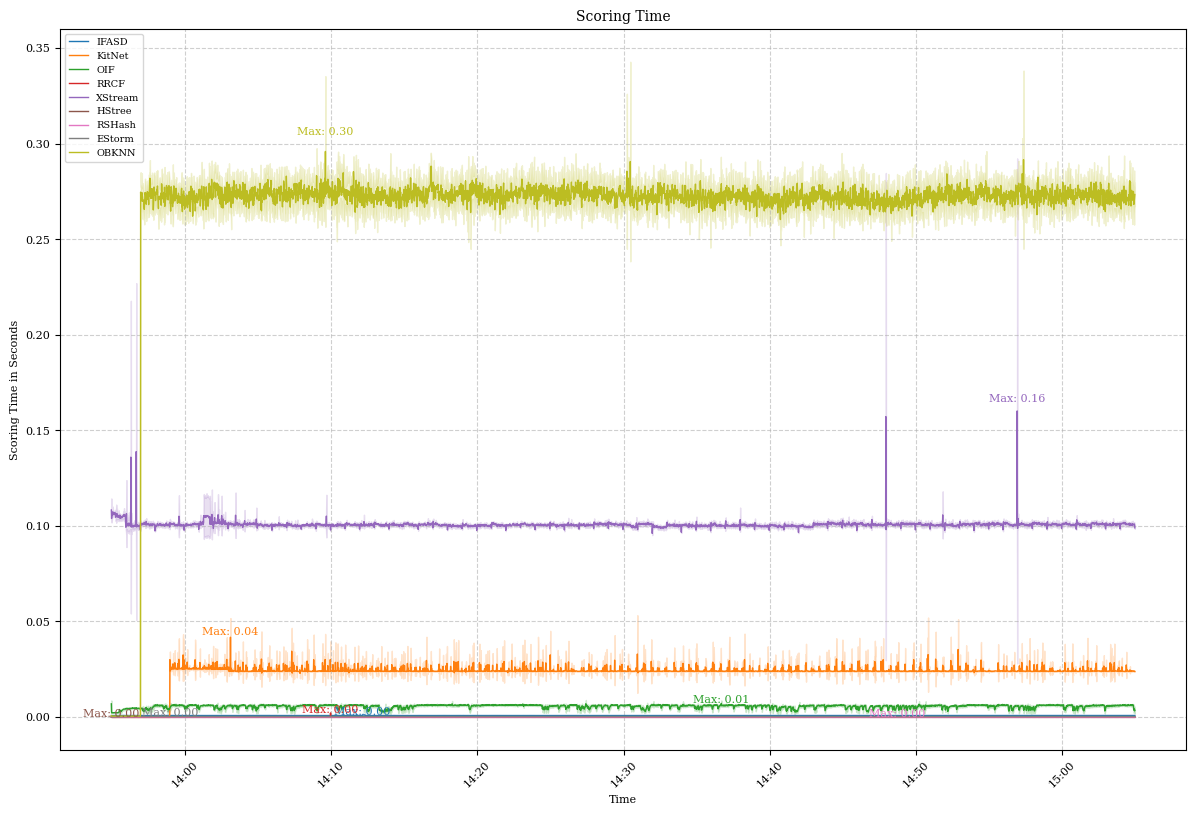

In [48]:
# Create a single figure
plt.figure(figsize=(12, 8))

# Group data by method and timestamp, calculating mean and standard deviation across iterations
grouped_data = filtered_data.groupby(['method', 'timestamp']).agg(
    mean_scoring_time_t=('scoring_time', 'mean'),
    std_scoring_time_t=('scoring_time', 'std')
).reset_index()


for m, color in zip(methods, color_list):
    
    method_data = grouped_data[grouped_data["method"] == m]

    scoring_time = method_data['mean_scoring_time_t']

    plt.plot(
        method_data['timestamp'],
        scoring_time,
        label=f'{m}',
        color=color
    )

    # Plot shaded area representing standard deviation
    plt.fill_between(
        method_data['timestamp'],
        (method_data['mean_scoring_time_t'] - method_data['std_scoring_time_t']),
        (method_data['mean_scoring_time_t'] + method_data['std_scoring_time_t']),
        color=color,
        alpha=0.2
    )

    
    max_time = scoring_time.max()
    max_idx = scoring_time.idxmax()
    max_timestamp = method_data.loc[max_idx, 'timestamp']  # Ensuring correct index

    # Format the max value properly
    formatted_max_time = f"{max_time:,.2f}"  # Adds commas and rounds to 2 decimals

    # Annotate the max value
    plt.annotate(
        f'Max: {formatted_max_time}', 
        xy=(max_timestamp, max_time), 
        xytext=(max_timestamp, max_time * 1.03),  # Adjusted for better visibility
        #arrowprops=dict(facecolor=color, arrowstyle='->'),
        color=color,
        ha='center'
    )
# Format the x-axis to show only the hours
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Scoring Time in Seconds')
plt.legend(loc='best')  # Place legend dynamically
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)  # Improve grid visibility
plt.tight_layout()
plt.title("Scoring Time")
#plt.savefig(f"/home/nicolas/spectral_anomaly_detector/notebooks/img_training_and_scoring_time/{SCENARIO}_scoring_time.png", format="png")
# Display the plot
plt.show()


In [49]:
# Group by method and compute scoring time statistics
scoring_time_stats = filtered_data.groupby(['method', 'timestamp'])['scoring_time'].agg(
    mean_scoring_time_t='mean',
).reset_index()

scoring_time_stats = scoring_time_stats.groupby(['method'])['mean_scoring_time_t'].agg(
    mean_time='mean',
    median_time='median',
    min_time='min',
    max_time='max',
    std_dev_time='std'
).reset_index()

# Sort by mean scoring time in ascending order
scoring_time_stats = scoring_time_stats.sort_values(by='mean_time', ascending=True)

# Display summary
scoring_time_stats

,method,mean_time,median_time,min_time,max_time,std_dev_time
7,RSHash,4.501068e-07,4.291534e-07,2.384186e-07,0.000001,7.616086e-08
1,HStree,8.933362e-06,8.869171e-06,3.719330e-06,0.000110,1.863572e-06
6,RRCF,2.768551e-05,2.689362e-05,1.349449e-05,0.002094,3.203927e-05
0,EStorm,2.706747e-04,2.727509e-04,5.912781e-06,0.000449,2.147128e-05
2,IFASD,7.555326e-04,7.542610e-04,7.318020e-04,0.001134,1.696003e-05
5,OIF,5.521493e-03,5.896091e-03,2.130795e-03,0.007104,8.815741e-04
3,KitNet,2.297259e-02,2.395854e-02,1.955032e-06,0.041732,5.761554e-03
8,XStream,1.006679e-01,1.005466e-01,9.604206e-02,0.160128,1.779806e-03
4,OBKNN,2.649349e-01,2.725791e-01,4.560947e-04,0.295900,4.551736e-02


In [50]:
filtered_data['total_time']=filtered_data['training_time']+filtered_data['scoring_time']

In [ ]:
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np

# --- 1. EXACT DIMENSION SETUP ---
# Standard column is ~3.5 inches. You are using 0.71 width.
# 3.5 * 0.71 = ~2.48 inches.
# We set the figure width to 2.5 inches so 10pt font STAYS 10pt.
FIG_WIDTH = 2.5  
FIG_HEIGHT = 2.2 # Compact height to match aspect ratio

# --- 2. PUBLICATION STYLE ---
plt.rcParams.update({
    'font.size': 10,              # Main text size (Labels)
    'axes.labelsize': 10,         # Axis labels
    'axes.titlesize': 10,         # Title
    'xtick.labelsize': 8,         # Ticks (Safe: 8pt > 7pt limit)
    'ytick.labelsize': 8,         # Ticks
    'legend.fontsize': 7,         # Minimum allowed size (7pt)
    'lines.linewidth': 1.2,       # Thinner lines for smaller chart
    'lines.markersize': 4,        # Smaller markers for smaller chart
    'font.family': 'serif',
    'figure.autolayout': False,   # We will use tight_layout manually
})

# --- 3. GRAYSCALE CYCLER ---
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'v', 'D', 'X', '*']
style_cycler = itertools.cycle(zip(line_styles, markers))

# --- 4. PLOTTING ---
# IMPORTANT: Define the specific small size here
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

for m, color in zip(methods, color_list):
    ls, mk = next(style_cycler)
    method_data = grouped_data[grouped_data["method"] == m]

    cumulative_training_time = method_data['mean_total_time_t'].expanding().sum()
    upper_bound = (method_data['mean_total_time_t'] + method_data['std_total_time_t']).expanding().sum()
    lower_bound = (method_data['mean_total_time_t'] - method_data['std_total_time_t']).expanding().sum()

    # Increase interval for this very small chart to avoid crowding
    marker_interval = max(1, len(method_data) // 6)

    plt.plot(
        range(len(method_data['timestamp'])), 
        cumulative_training_time,
        label=f'{m}',
        color=color,
        linestyle=ls,       
        marker=mk,          
        markevery=marker_interval, 
        markersize=4,       
        linewidth=1.2       
    )

    plt.fill_between(
        range(len(method_data['timestamp'])), 
        lower_bound,
        upper_bound,
        color=color,
        alpha=0.15,         
        edgecolor=None      
    )

    # Simplified Annotation for small space
    max_time = cumulative_training_time.max()
    max_timestamp = len(method_data['timestamp']) 
    
    if m in ["OBKNN", "XStream", "KitNet"]:
        plt.annotate(
            f'{max_time:.1f}', # Shortened text format
            xy=(max_timestamp, max_time), 
            xytext=(max_timestamp, max_time * 1.1),
            color='black', 
            fontsize=7,        # Minimal safe size
            fontweight='bold',
            ha='center',
            bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.6)
        )

# --- 5. COMPACT FORMATTING ---
# Shortened labels are required for 2.5 inch width
plt.xlabel('# Instances') 
plt.ylabel('Time (s)')

plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Compact Legend
plt.legend(
    loc='upper left', 
    frameon=True, 
    fontsize=7, 
    handlelength=1.5, # Shorter lines in legend
    handletextpad=0.4, # Closer text
    borderaxespad=0.2
)

# Rotate ticks heavily to fit in 2.5 inches
plt.xticks(rotation=45)

# Ultra-tight layout for small figures
plt.tight_layout(pad=0.5)

output_path = current_dir / 'notebooks' / 'img_training_and_scoring_time' / f"{SCENARIO}_accum_total_time.pdf"
plt.savefig(output_path, format="pdf", bbox_inches='tight')
plt.show()

NameError: name 'filtered_data' is not defined